## 1. Quadratic programming and QP-solver

Rewriting our inequalities to a similar form:
$$x_1 + x_2 \leq 5, \; -x_1 \leq 0 ; x_1 \leq 3, \; -x_1 - x_2 \leq 2$$

In [1]:
from cvxopt import matrix, solvers
import numpy as np
%matplotlib inline
solvers.options['show_progress'] = False

P = matrix([[2., 0.],[0., 8.]])
q = matrix([-8.,-5.])
G = matrix([[1., 1., -1. , -1.],[1., 0., 0., -1.]])
h = matrix([5., 3., 0., -2.])
sol = solvers.coneqp(P, q, G, h)
print(sol['x'])


[ 3.00e+00]
[ 6.25e-01]



Seeing that in our solution $$x_1 = 3, x_2 = 0.625,$$ we can conclude that 3 of our constraints are not active (1st, 2nd and 4th), so we can remove them without altering the answer:

In [2]:
G = matrix([[1.],[ 0.]])
h = matrix([ 3.])
sol = solvers.coneqp(P, q, G, h)
print(sol['x'])

[ 3.00e+00]
[ 6.25e-01]



### Reduce SVM optimisation problem to QP, and implement Linear SVM using QP-solver
I've made one vector of variables - $x = (b, w_1,..,w_d, \xi_1,..,\xi_N)$. And rewrote the inequality constraints to the same form as in the first task: $$-y_n(w^Tx_n + b) - \xi_n \leq -1 ;$$ $$ -\xi_n \leq 0 ;$$ $$n = 1,..,N.$$ Then composed big matrices to satisfy cvxopt solver.

In [2]:
from sklearn.base import BaseEstimator
import numpy as np

#C = None
b = None
ksi = None
w = None

class LinearSVM(BaseEstimator):
    def __init__(self, C, transform=None):
        self.C = C
        self.transform = transform
        
    def fit(self, X, y):
        #X,y = matrix(X), matrix(y)
        sol = self.compute_multipliers(X, y)
        self.b, self.w, self.ksi = np.split(sol['x'], [1,X.size[1]+1])
        #return (self.b, self.w, self.ksi)
        
    def compute_multipliers(self, X, y):
        #X,y = matrix(X), matrix(y)
        n_samples, n_features = X.size
        
        
        P = matrix(np.hstack((np.zeros(shape = (n_features, 1)),np.identity(n_features),np.zeros(shape=(n_features,n_samples)))))
        P = matrix(np.vstack((np.zeros(n_samples+n_features+1), P, np.zeros(shape = (n_samples, n_samples+n_features+1)) )))
        
        q =  matrix(self.C*np.hstack((np.zeros(n_features+1),np.ones(n_samples))))
        
        G = matrix(np.hstack((-y,-np.multiply(X,y),np.identity(n_samples) * -1.)))
        G = matrix(np.vstack((G, np.hstack((np.zeros(shape = (n_samples, n_features + 1)), -np.identity(n_samples))) )) )
        
        h = matrix(np.hstack((np.ones(n_samples) * -1., np.zeros(n_samples)))) 
        
        solution = solvers.qp(P, q, G, h)
        
        #return solution['x']
        return solvers.qp(P, q, G, h)
    def sup_vec(self, X, y):
        #self.fit(X,y)
        res = np.multiply(self.predict_proba(X),y)
        ksi = np.subtract(np.ones(len(self.ksi)),self.ksi.flatten())
        res = np.subtract(res.flatten(),ksi)
        #return enumerate(res[abs(res)<=10**-6]).np.indices
        return np.where(abs(res)<=10**-7)[0]       
    def predict_proba(self, X):
        #self.fit(X,y)
        return (np.dot(X, self.w) + self.b)
            
    def predict(self, X):
        return np.sign(self.predict_proba(X))

## Generate different 2D sample for binary classification task:

### Linearly separable

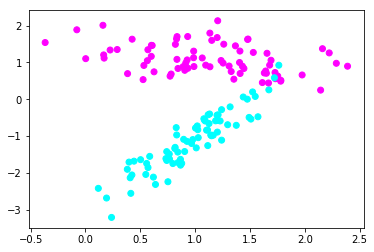

In [3]:
from sklearn.datasets import *
import matplotlib.pyplot as plt
X_l, y_l = make_classification(n_samples=150, n_features=2, n_classes=2, n_redundant=0, n_clusters_per_class=1, random_state=15)

y_l[y_l<=0] = -1
plt.scatter(X_l[:, 0], X_l[:, 1], c=y_l, cmap='cool')

### With separable classes, but not linearly

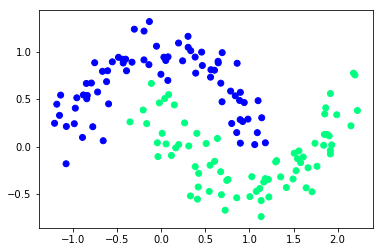

In [4]:
X_nl, y_nl = make_moons(n_samples=150, shuffle=True, noise=0.15, random_state=42)

y_nl[y_nl<=0] = -1
#y_nl = [y if y > 0 else -1 for y in y_nl]
plt.scatter(X_nl[:, 0], X_nl[:, 1], c=y_nl, cmap='winter')

### Not-separable classes in that feature space

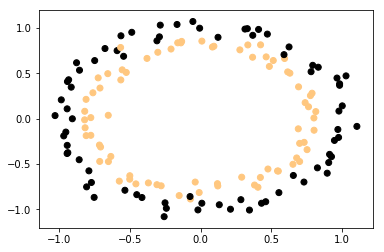

In [5]:
X_ns, y_ns = make_circles(n_samples=150, shuffle=True, noise=0.05, random_state=52, factor=0.8)

y_ns[y_ns<=0] = -1
plt.scatter(X_ns[:, 0], X_ns[:, 1], c=y_ns, cmap='copper')


In [6]:
#training of all 3

svm_l = LinearSVM(C=1)
svm_nl = LinearSVM(C=1)
svm_ns = LinearSVM(C=1)
X_l,y_l,X_nl,y_nl,X_ns,y_ns = matrix(X_l), matrix(y_l), matrix(X_nl), matrix(y_nl), matrix(X_ns), matrix(y_ns)
svm_l.fit(X_l,y_l)
svm_nl.fit(X_nl, y_nl)
svm_ns.fit(X_ns,y_ns)

### Test linear SVM on these samples. Draw plots with separating hyperplane, and with level lines, which constraint "street" $f(x)=\pm 1$. Use different point shape or size for support vectors. Build classifier with different $C$

In [9]:
def print_svm(model, name, X, y, fig_size = (5,5), fig_num = 1, subplot = 111):
    
    plt.figure(fig_num, figsize=fig_size, dpi=100)
    plt.subplot(subplot)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')

    xvals = np.linspace(-4, 4, 200)
    yvals = np.linspace(-4, 4, 200)
        
    xx, yy = np.meshgrid(xvals, yvals)
    data = np.c_[xx.ravel(), yy.ravel()]    
    zz = np.reshape(model.predict_proba(data), xx.shape)

    # Decision rule color encoding
    plt.pcolormesh(xx, yy, zz, cmap='summer', zorder=0)

    # Level lines of 0.5
    plt.contour(xx, yy, zz, levels=([-1, 0, 1]), linestyles = ['-','--','-'], colors='k', linewidths=1.5, zorder=1)

    # set support vectors
    sup = model.sup_vec(X,y)
    map(lambda i: plt.plot(X[i,0],X[i,1],'go'),sup)
    
    plt.xlim([-1.5, 3])
    plt.ylim([-2, 2])
    _ = plt.title(name)

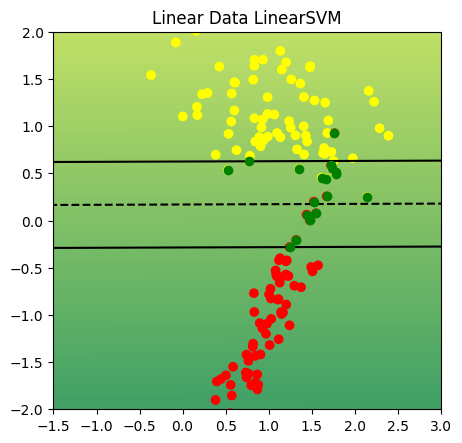

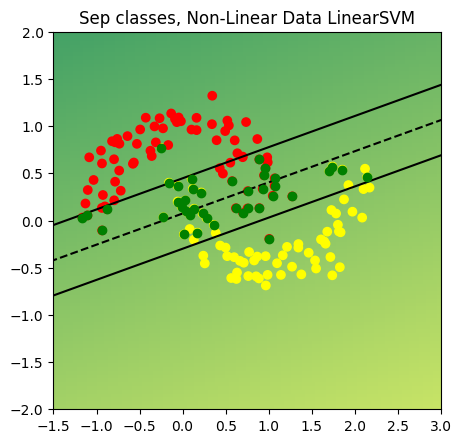

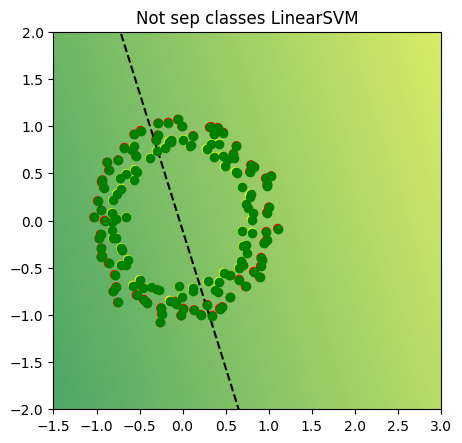

In [10]:
# Green points are supports vectors
print_svm(svm_l, 'Linear Data LinearSVM', X_l, y_l, fig_num = 1)
print_svm(svm_nl, 'Sep classes, Non-Linear Data LinearSVM', X_nl, y_nl, fig_num = 2)
print_svm(svm_ns, 'Not sep classes LinearSVM', X_ns, y_ns, fig_num = 3)

#### Different C for linear classes

Basically, what we see here is that support vectors are depleting. We'll see the picture further in a more broad range of parameter C.

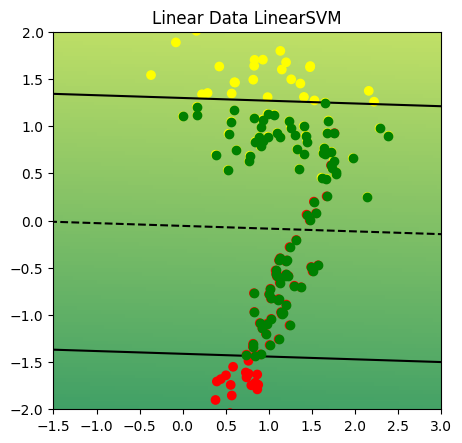

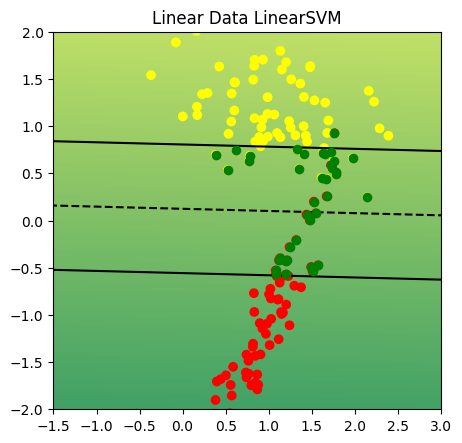

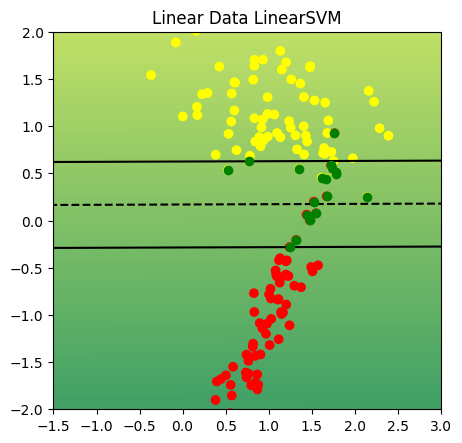

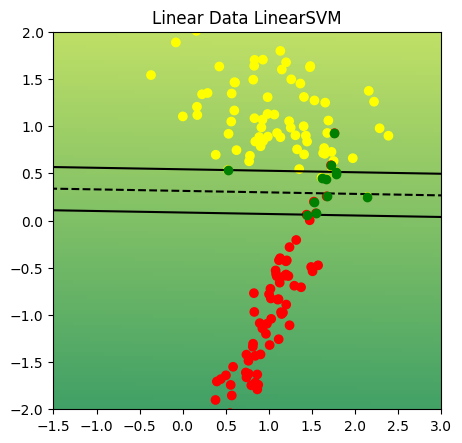

In [11]:
C_1 = [0.01,0.1,1,10]
SVM = map(LinearSVM, C_1)
map(lambda x: x.fit(X_l,y_l),SVM)
for i, svm in zip(np.arange(4), SVM):
    print_svm(svm, 'Linear Data LinearSVM', X_l, y_l, fig_num = i)


### How the number of support vectors depends on parameter $C$?

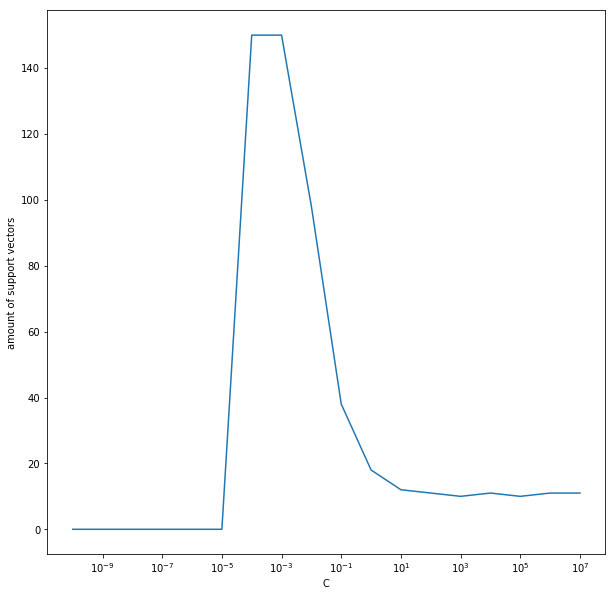

In [12]:
C_2 = np.logspace(-10, 7, 18) # a list of C parameters
#C = np.arange(-10,7)
svm_l = map(LinearSVM, C_2) #creating of models
map(lambda x: x.fit(X_l,y_l),svm_l) #training
sup_vec = map(lambda clss: clss.sup_vec(X_l,y_l),svm_l) #co
amount_of_sv = map(len, sup_vec)
plt.figure(figsize = (10,10))
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('amount of support vectors')

plt.plot(C_2, amount_of_sv)

### Using explicit feature transformation train linear SVM to separate non-leary separable classes with a quadratic hyperplane. Show it on the plot.

I've used polytransformation. Now division is more accurate, as it can be obviously seen on the plot.

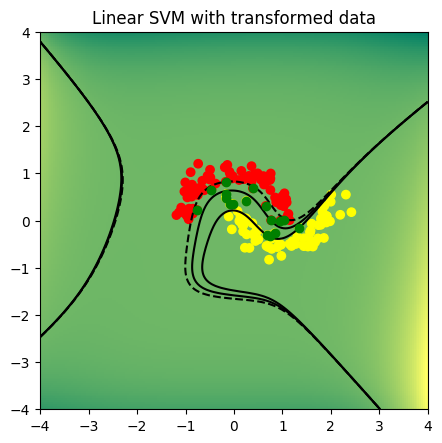

In [15]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(6)
poly.fit(X_nl)

X_nl_tr = matrix(poly.transform(X_nl))

svm_not_lin = LinearSVM(C=1)
svm_not_lin.fit(X_nl_tr, y_nl)

plt.figure(figsize=(5, 5), dpi=100)
plt.scatter(X_nl[:, 0], X_nl[:, 1], c=y_nl, cmap='autumn')

xvals = np.linspace(-4, 4, 200)
yvals = np.linspace(-4, 4, 200)
xx, yy = np.meshgrid(xvals, yvals)

data = poly.transform(np.c_[xx.ravel(), yy.ravel()])
zz = np.reshape(svm_not_lin.predict_proba(data), xx.shape)

# Decision rule color encoding
plt.pcolormesh(xx, yy, zz, cmap='summer', zorder=0)

# Level lines of 0.5
plt.contour(xx, yy, zz, levels=([-1, 0, 1,]), colors='k', linewidths=1.5, zorder=1)

# set support vectors
markers_on = svm_not_lin.sup_vec(X_nl_tr,y_nl)
for item in markers_on:
    x = X_nl[item,:]
    plt.plot(x[0], x[1], 'go')

plt.xlim([-4, 4])
plt.ylim([-4, 4])
_ = plt.title('Linear SVM with transformed data')

## 3. Dual problem and Kernel SVM

Implement kernel SVM, using QP-solver

In [7]:
import numpy as np
import numpy.linalg as la


class Kernel(object):
    @staticmethod
    def linear():
        def f(x, y):
            return np.inner(x, y)
        return f

    @staticmethod
    def gaussian(sigma):
        def f(x, y):
            exponent = -la.norm(x-y) ** 2 / (2 * sigma ** 2)
            return np.exp(exponent)
        return f

    @staticmethod
    def _polykernel(dimension, offset):
        def f(x, y):
            return (offset + np.inner(x, y)) ** dimension
        return f

In [9]:
from sklearn.base import BaseEstimator
import numpy as np

#C = None
b = None
ksi = None
w = None
X = None
y = None

class SVM_ker(BaseEstimator):
    def __init__(self, C, kernel, transform=None):
        self.C = C
        self.kernel = kernel
        self.transform = transform        
    def _gram_matrix(self, X):
        n_samples, n_features = X.size
        K = np.zeros((n_samples, n_samples))
        for i in np.arange(n_samples):
            for j  in np.arange(n_samples):
                K[i, j] = self.kernel(X[i,:], X[j,:])
        return K
    def fit(self, X, y):
        self.y = y
        self.X = X
        self.a = self.compute_multipliers(X,y)['x']
        self.get_b(X,y)
    def compute_multipliers(self, X, y):
        n_samples, n_features = X.size
        K = self._gram_matrix(X)
        
        P = matrix(np.outer(y,y) * K)
        q = matrix(-1 * np.ones(n_samples))
        
        G = matrix(np.vstack((np.identity(n_samples), np.identity(n_samples) * -1)))
        h = matrix(np.hstack((np.ones(n_samples)*self.C, np.zeros(n_samples))))
        
        A = matrix(y.T * np.ones(n_samples))
        b = matrix(.0) 
        solution = solvers.qp(P, q, G, h, A, b)
        return solution
    def sup_vec(self, X, y):
        sol = self.compute_multipliers(X,y)
        return np.where(np.array(self.a) > 10**-6)[0]
    def get_b(self, X, y):
        n_samples, n_features = X.size
        K = self._gram_matrix(X)
        sv = self.sup_vec(X,y)
        t = np.zeros(n_samples)
        for i in sv:
             t[i] = y[i] - self.a[i]*y[i]*np.sum(np.take(K[i,:], indices = tuple(sv)))
        self.b = np.mean(np.take(t, indices = tuple(sv)))
    def predict_proba(self, X):
        n_samples, n_features = X.size
        n_samples1, n_features1 = self.X.size
        gr = matrix(np.zeros((n_samples1, n_samples)))
        for i in np.arange(n_samples1):
            for j  in np.arange(n_samples):
                gr[i,j] = self.kernel(self.X[i,:], X[j,:])
        pred = map(lambda i : np.sum(np.multiply(self.a,self.y).flatten() * gr[:,i].T), np.arange(n_samples)) + self.b       
        return pred
    def predict(self, X):
        return np.sign(self.predict_proba(X))
         

In [14]:
def print_svm_ker(model, name, X, y, fig_size = (5,5), fig_num = 1, subplot = 111):
    
    plt.figure(fig_num, figsize=fig_size, dpi=100)
    plt.subplot(subplot)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')

    xvals = np.linspace(-4, 4, 100)
    yvals = np.linspace(-4, 4, 100)
        
    xx, yy = np.meshgrid(xvals, yvals)
    data = np.c_[xx.ravel(), yy.ravel()]    
    zz = np.reshape(model.predict_proba(matrix(data)), xx.shape)

    # Decision rule color encoding
    plt.pcolormesh(xx, yy, zz, cmap='summer', zorder=0)

    # Level lines of 0.5
    plt.contour(xx, yy, zz, levels=([-1, 0, 1]), linestyles = ['-','--','-'], colors='k', linewidths=1.5, zorder=1)

    # set support vectors
    sup = model.sup_vec(X,y)
    map(lambda i: plt.plot(X[i,0],X[i,1],'go'),sup)
    
    plt.xlim([-1.5, 3])
    plt.ylim([-2, 2])
    _ = plt.title(name)

Test linear SVM on these samples. Draw plots with separating hyperplane, and with level lines, which constraint "street" f(x)=±1f(x)=±1. Use different point shape or size for support vectors. Test different kernels

In [11]:
ker = Kernel()
svm_k1 = SVM_ker(C = 0.1, kernel = ker.linear())
svm_k1.fit(X_l,y_l)
svm_k2 = SVM_ker(C = 1, kernel = ker._polykernel(3,1))
svm_k2.fit(X_nl,y_nl)
svm_k3 = SVM_ker(C = 0.001, kernel = ker.gaussian(3))
svm_k3.fit(X_ns,y_ns)

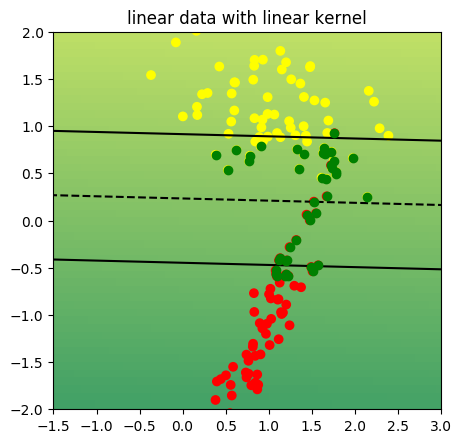

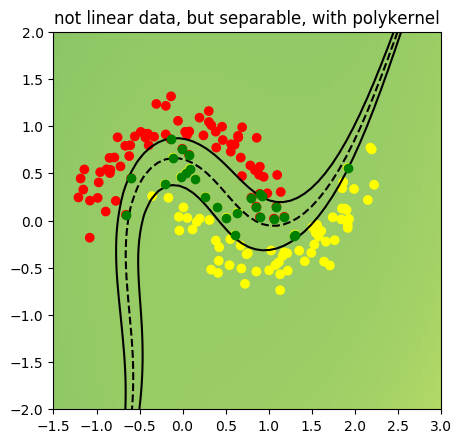

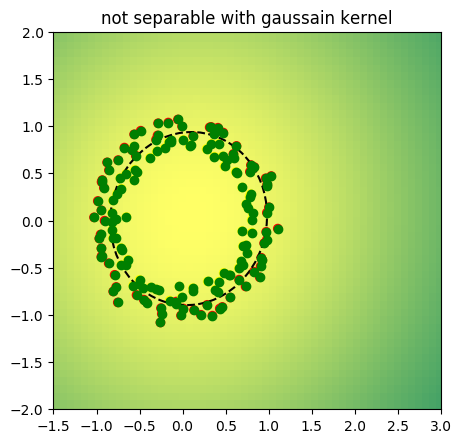

In [15]:
print_svm_ker(svm_k1, 'linear data with linear kernel', X_l, y_l, fig_num = 1)
print_svm_ker(svm_k2, 'not linear data, but separable, with polykernel', X_nl, y_nl, fig_num = 2)
print_svm_ker(svm_k3, 'not separable with gaussain kernel', X_ns, y_ns, fig_num = 3)

### Describe SVM with polynomial kernel behavior when you vary parameters CC and kernel degree dd.

I've drawn plenty of plots, but it's still the best one is in the upper three, degree = 6 works best for that kind of data.

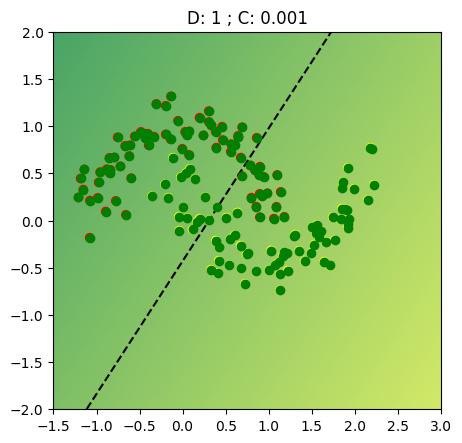

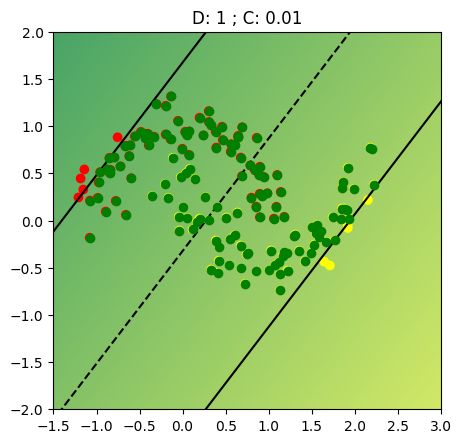

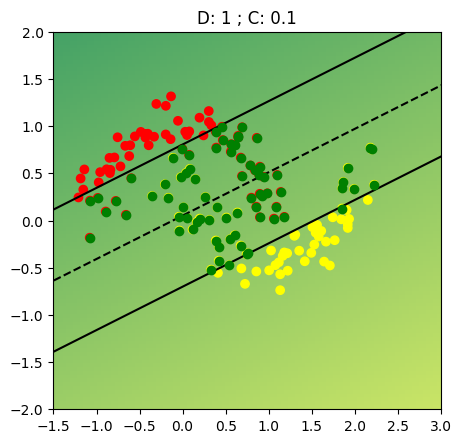

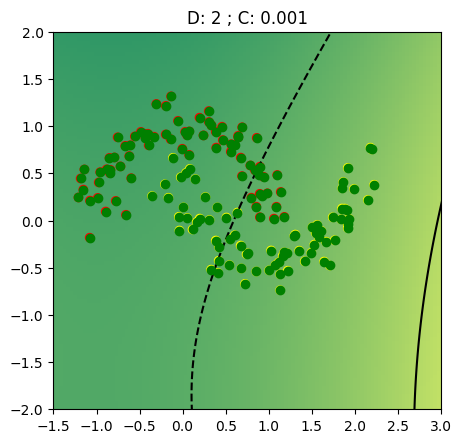

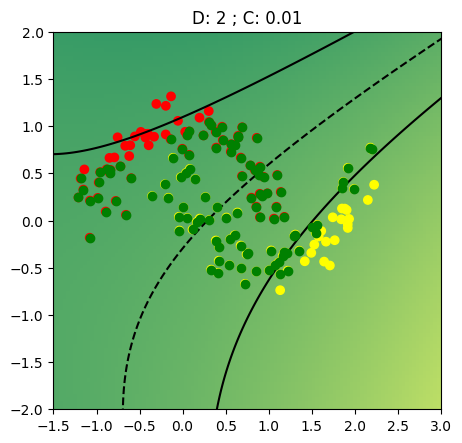

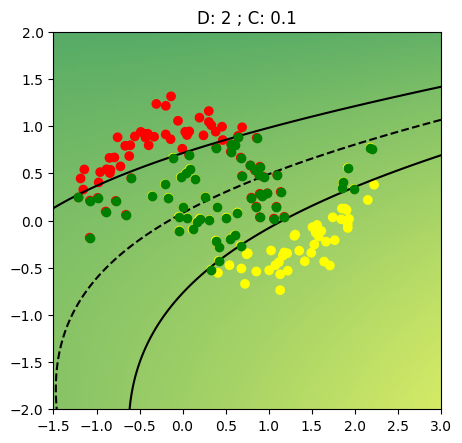

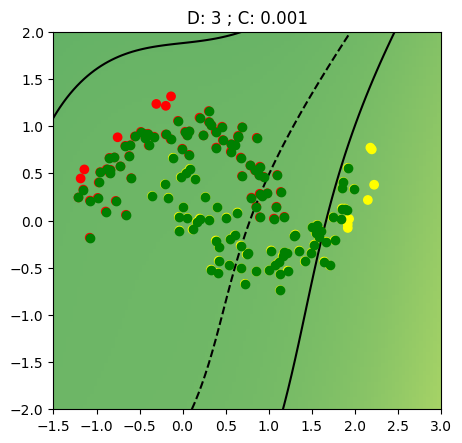

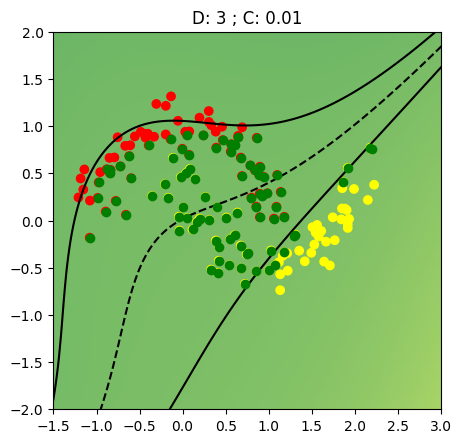

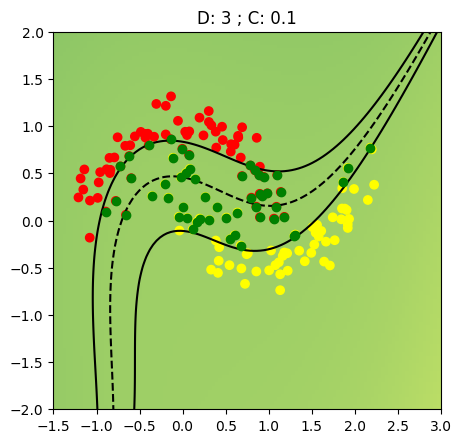

In [114]:
fig=4
for d in range(1,4):
    c = 1e-3
    for i in range(1,4):
        svm_k = SVM_ker(C = c, kernel = ker._polykernel(d,1))
        svm_k.fit(X_nl, y_nl)

        print_svm_ker(svm_k, 'D: ' + str(d) + ' ; C: ' + str(c), X_nl, y_nl, 
                  fig_size=(5,5), fig_num = fig, subplot=111)
        c = c * 10
        fig += 1

### Descrive SVM with RBF kernel behavior when you vary CC and σσ. Vary parameters at logarithmic scale. Which parameters lead to overfitting, which parameters give low quality model.

The best results are for sigma 1, and C parameter doesn't influence much there. Sigma 10 with every C parameter yield a low quality model. Overfitting is increasing with sigma decreasing

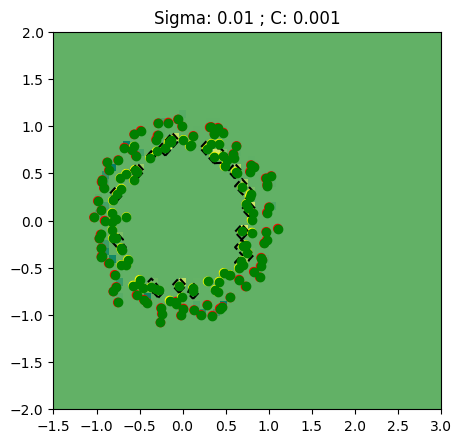

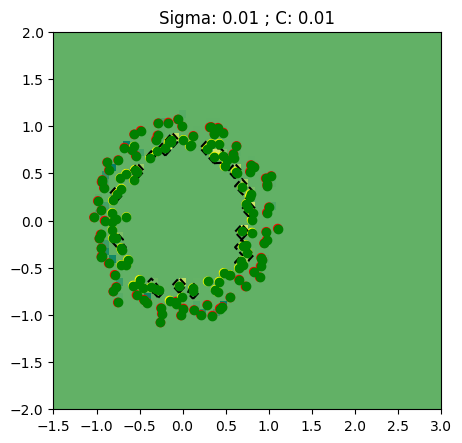

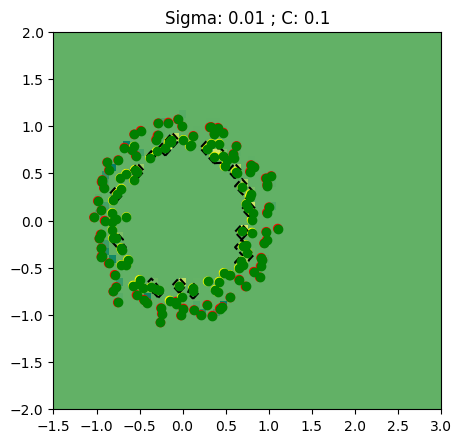

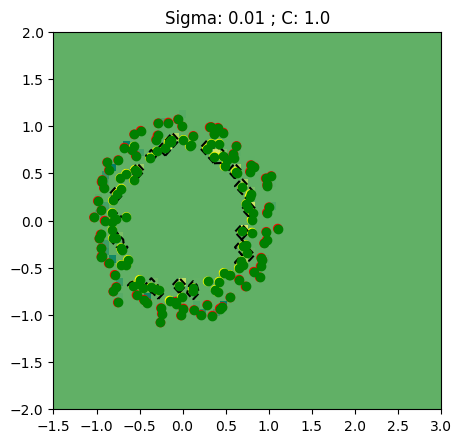

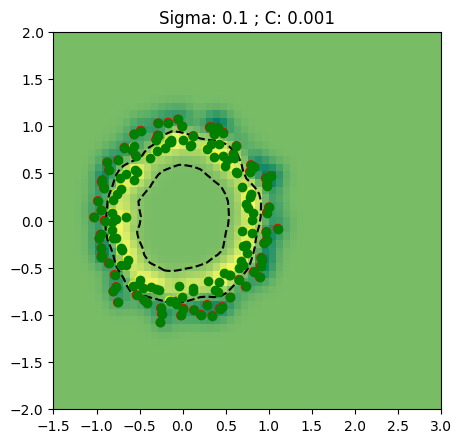

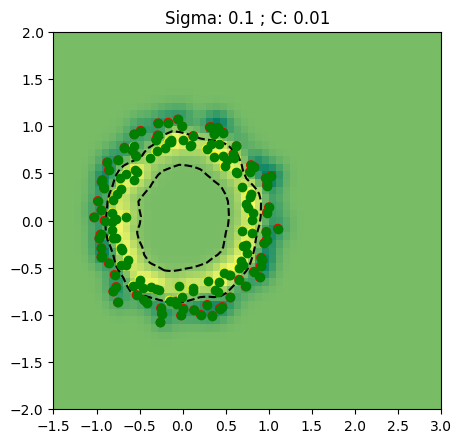

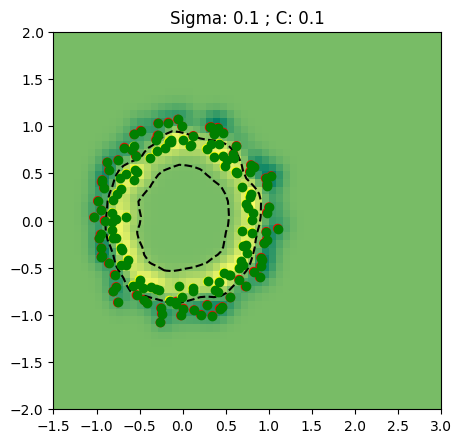

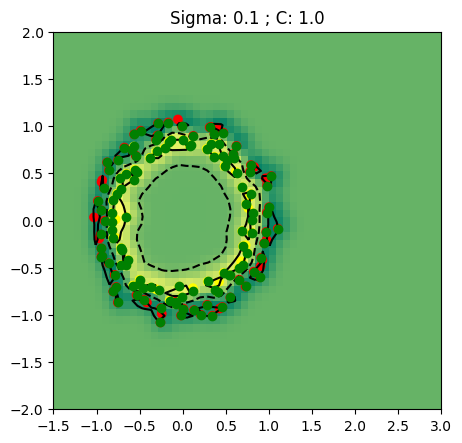

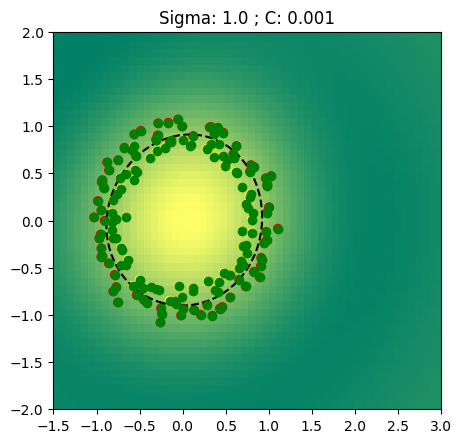

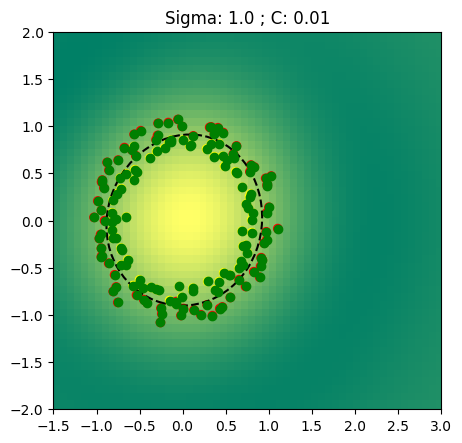

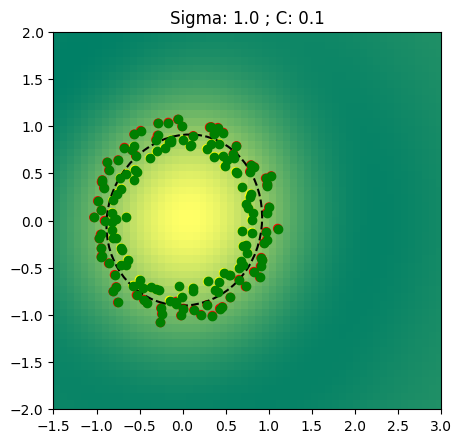

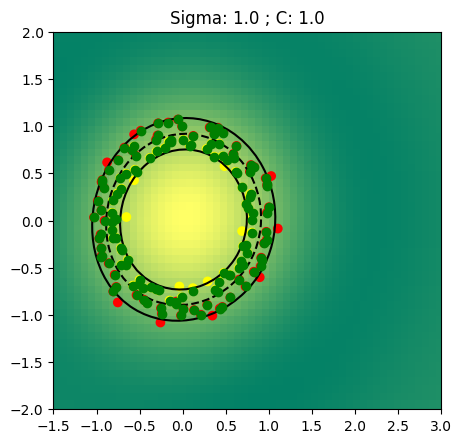

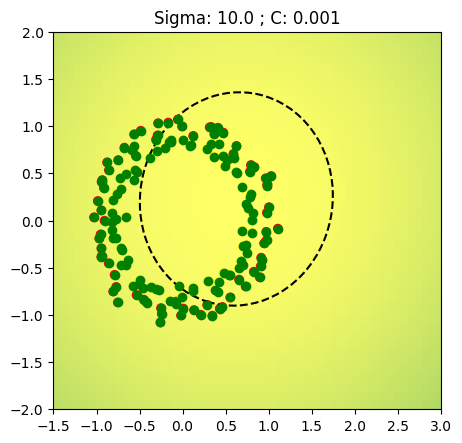

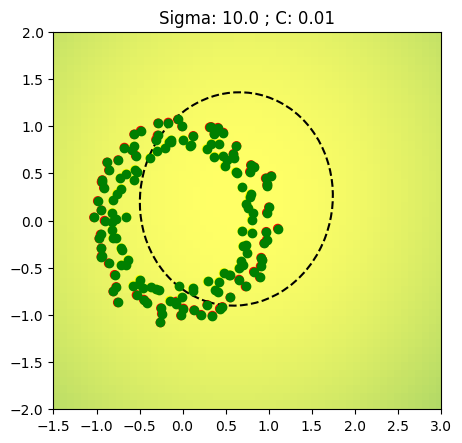

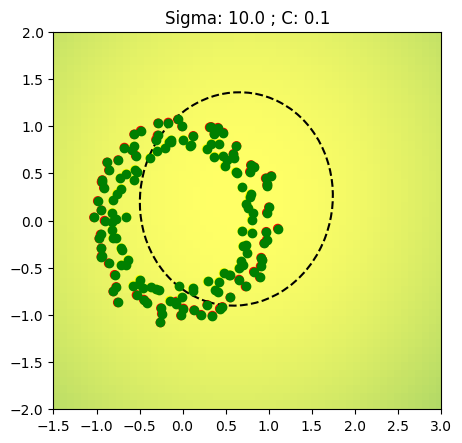

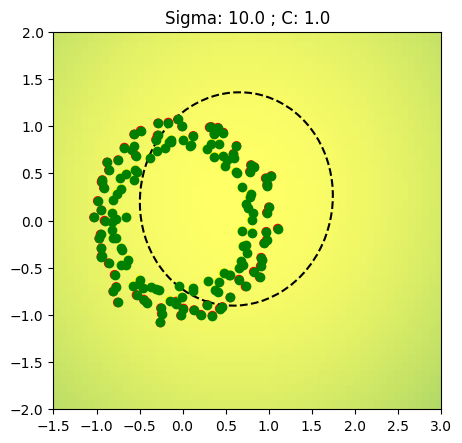

In [16]:
fig=4
sig = 1e-2
for j in range(1,5):
    c = 1e-3
    for i in range(1,5):
        svm_k = SVM_ker(C = c, kernel = ker.gaussian(sig))
        svm_k.fit(X_ns, y_ns)

        print_svm_ker(svm_k, 'Sigma: ' + str(sig) + ' ; C: ' + str(c), X_ns, y_ns, 
                  fig_size=(5,5), fig_num = fig,subplot=111)
        c = c * 10
        fig += 1
    sig = sig * 10

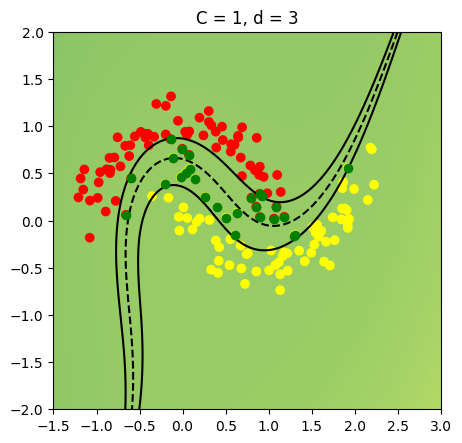

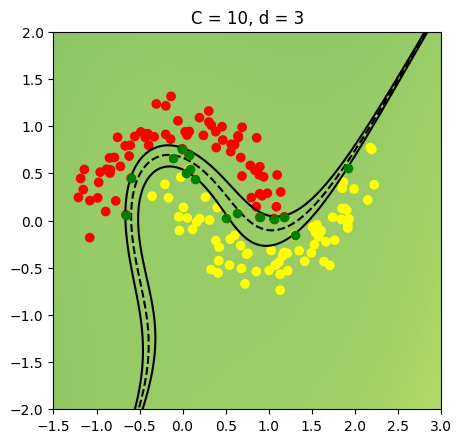

In [116]:
svm_k2 = SVM_ker(C = 1, kernel = ker._polykernel(3,1))
svm_k2.fit(X_nl,y_nl)
print_svm_ker(svm_k2, 'C = 1, d = 3', X_nl, y_nl, fig_num = 2)
svm_k5 = SVM_ker(C = 10,kernel = ker._polykernel(3,1))
svm_k5.fit(X_nl, y_nl)
print_svm_ker(svm_k5, 'C = 10, d = 3', X_nl, y_nl, fig_num = 3)

#print_svm(svm_k4, 'not linear data, but separable, with polykernel', X_nl, y_nl, fig_num = 2)